In [32]:
import pandas as pd
import os
import re
from openpyxl import load_workbook
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

In [33]:
class SwissRentalDataExtractor:
    """
    A class to extract rental price data from Swiss rental price Excel files.
    The Excel files contain data on average rental price per square meter by 
    construction period and canton in Switzerland.
    """
    
    def __init__(self, output_format='json'):
        """
        Initialize the extractor.
        
        Args:
            output_format (str): Format to save extracted data ('csv', 'json', or 'excel')
        """
        self.output_format = output_format
        self.supported_formats = ['csv', 'json', 'excel']
        if self.output_format not in self.supported_formats:
            raise ValueError(f"Output format must be one of {self.supported_formats}")
    
    def extract_data(self, file_path, output_dir=None):
        """
        Extract data from an Excel file containing Swiss rental prices.
        
        Args:
            file_path (str): Path to the Excel file
            output_dir (str, optional): Directory to save extracted data. 
                                        If None, saves in the same directory as the input file.
        
        Returns:
            dict: Dictionary with sheet names as keys and DataFrames as values
        """
        print(f"Processing file: {file_path}")
        
        # Set output directory
        if output_dir is None:
            output_dir = os.path.dirname(file_path)
        os.makedirs(output_dir, exist_ok=True)
        
        # Get base filename for output
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        
        # Store all extracted data
        all_data = {}
        
        # Use pandas to read all sheets
        xls = pd.ExcelFile(file_path)
        
        # Process each sheet
        for sheet_name in xls.sheet_names:
            # Extract year from sheet name if possible, otherwise use sheet name
            year = sheet_name
            if sheet_name.isdigit():
                year = sheet_name
            else:
                # Try to find a 4-digit year in the sheet name
                match = re.search(r'\b(19|20)\d{2}\b', sheet_name)
                if match:
                    year = match.group(0)
                # Check title cell for year (in case it's stored as A1 or similar)
                try:
                    df_check = pd.read_excel(file_path, sheet_name=sheet_name, nrows=1, header=None)
                    # Look for year in first cell
                    if df_check.iloc[0, 0]:
                        year_match = re.search(r'\b(19|20)\d{2}\b', str(df_check.iloc[0, 0]))
                        if year_match:
                            year = year_match.group(0)
                except:
                    pass
            
            print(f"  Processing sheet: {sheet_name} (Year: {year})")
            
            # Read in the entire sheet
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            
            # Find the row with "Bauperiode" which is the header for construction periods
            bauperiode_row = None
            total_row = None
            
            for i, row in df.iterrows():
                row_values = [str(val).strip() if pd.notna(val) else "" for val in row.values]
                if "Bauperiode" in row_values:
                    bauperiode_row = i
                if "Total" in row_values:
                    total_row = i
                    # Typically, if we've found both rows, we can break
                    if bauperiode_row is not None:
                        break
            
            if bauperiode_row is None or total_row is None:
                print(f"  Warning: Could not find required rows in sheet {sheet_name}, skipping.")
                continue
            
            # Get the actual construction periods from the row BELOW "Bauperiode" row
            periods_row = bauperiode_row
            
            # Get column pairs for periods and their confidence intervals
            column_pairs = []
            
            # We go through the "Bauperiode" row to find the period columns
            for col in range(df.shape[1]):
                cell_value = df.iloc[periods_row, col]
                if pd.notna(cell_value) and "Bauperiode" in str(cell_value):
                    # Now check the cells in the row below for actual construction periods
                    # Skip 1 row to get to the actual periods
                    for period_col in range(col, df.shape[1], 2):  # Assume every other column is a period
                        period_value = df.iloc[periods_row + 1, period_col]
                        
                        # If we hit an empty cell, we might be at the end of the periods
                        if pd.isna(period_value) or str(period_value).strip() == "":
                            continue
                            
                        # Skip if this is likely a confidence interval column
                        if any(ci_term in str(period_value).lower() for ci_term in ['vertrauens', 'interval', '±']):
                            continue
                            
                        # Check if next column is available for confidence interval
                        ci_col = period_col + 1
                        if ci_col < df.shape[1]:
                            column_pairs.append((period_col, ci_col, period_value))
                    
                    # Once we've processed the Bauperiode header, we can break
                    break
            
            # If we couldn't find any construction periods, try an alternative approach
            if not column_pairs:
                print(f"  Warning: Could not identify construction periods in sheet {sheet_name}, trying alternative approach.")
                
                # Look for the construction periods in the row below "Bauperiode"
                construction_periods_row = bauperiode_row + 1
                
                for col in range(1, df.shape[1], 2):  # Assume construction periods are in odd-numbered columns
                    period_value = df.iloc[construction_periods_row, col]
                    
                    if pd.isna(period_value) or str(period_value).strip() == "":
                        continue
                        
                    # Skip if this is likely a confidence interval column
                    if any(ci_term in str(period_value).lower() for ci_term in ['vertrauens', 'interval', '±']):
                        continue
                        
                    # Check if next column is available for confidence interval
                    ci_col = col + 1
                    if ci_col < df.shape[1]:
                        column_pairs.append((col, ci_col, period_value))
            
            # Print found construction periods for debugging
            periods = [pair[2] for pair in column_pairs]
            print(f"  Found {len(periods)} construction periods: {periods}")
            
            # Start row for cantons (usually below "Total" row)
            canton_start_row = total_row + 1
            
            # Initialize data structure for nested JSON
            nested_data = []
            
            # Initialize flat data structure for DataFrame (for CSV/Excel and analysis)
            flat_data = {
                "year": [],
                "canton": [],
                "construction_period": [],
                "avg_price_per_sqm": [],
                "confidence_interval": []
            }
            
            # Extract data for each canton and construction period
            for row in range(canton_start_row, df.shape[0]):
                canton = df.iloc[row, 0]
                
                # Skip empty rows or non-canton rows
                if pd.isna(canton) or str(canton).strip() == "":
                    continue
                
                canton_data = {"year": year, "canton": str(canton).strip(), "construction_periods": []}
                
                # Extract data for each construction period for this canton
                for period_col, ci_col, period_name in column_pairs:
                    # Get price and confidence interval
                    price = df.iloc[row, period_col]
                    ci = df.iloc[row, ci_col] if ci_col < df.shape[1] else None
                    
                    # Handle numeric conversion safely - skip non-numeric values
                    try:
                        # Convert to string first to handle cases like 'X ' or special characters
                        price_str = str(price).strip()
                        # Skip cells with non-numeric data like 'X', '-', etc.
                        if not re.match(r'^-?\d+\.?\d*$', price_str):
                            continue
                        
                        price_float = float(price_str)
                        
                        # Handle confidence interval similarly
                        ci_float = None
                        if pd.notna(ci):
                            ci_str = str(ci).strip()
                            if re.match(r'^-?\d+\.?\d*$', ci_str):
                                ci_float = float(ci_str)
                        
                        # Add to nested structure
                        period_data = {
                            "construction_period": str(period_name).strip(),
                            "avg_price_per_sqm": price_float,
                            "confidence_interval": ci_float
                        }
                        canton_data["construction_periods"].append(period_data)
                        
                        # Add to flat structure
                        flat_data["year"].append(year)
                        flat_data["canton"].append(str(canton).strip())
                        flat_data["construction_period"].append(str(period_name).strip())
                        flat_data["avg_price_per_sqm"].append(price_float)
                        flat_data["confidence_interval"].append(ci_float)
                    except Exception as e:
                        print(f"  Warning: Could not convert price '{price}' to float for canton '{canton}', construction period '{period_name}'. Error: {e}")
                        continue
                
                # Only add canton if it has at least one construction period
                if canton_data["construction_periods"]:
                    nested_data.append(canton_data)
            
            # Create DataFrame from flat data
            result_df = pd.DataFrame(flat_data)
            
            # Only save if we have data
            if not result_df.empty:
                all_data[sheet_name] = result_df
                
                # Save individual sheet data
                if self.output_format == 'json':
                    # For JSON, save the nested structure which is more natural
                    with open(f"{os.path.join(output_dir, f"{base_filename}_{sheet_name}")}.json", 'w', encoding='utf-8') as f:
                        json.dump(nested_data, f, ensure_ascii=False, indent=2)
                else:
                    # For CSV and Excel, use the flattened structure
                    self._save_data(result_df, os.path.join(output_dir, f"{base_filename}_{sheet_name}"))
                
                print(f"  Extracted {len(result_df)} data points for sheet {sheet_name}")
            else:
                print(f"  Warning: No data extracted for sheet {sheet_name}")
        
        # Combine all sheets into a single dataset
        if all_data:
            combined_df = pd.concat(all_data.values(), ignore_index=True)
            
            if self.output_format == 'json':
                # For combined JSON, we need to aggregate by year and canton
                combined_nested_data = []
                
                # Group by year and canton
                for year_val in combined_df['year'].unique():
                    year_df = combined_df[combined_df['year'] == year_val]
                    for canton in year_df['canton'].unique():
                        canton_df = year_df[year_df['canton'] == canton]
                        
                        canton_data = {"year": year_val, "canton": canton, "construction_periods": []}
                        
                        for _, row in canton_df.iterrows():
                            period_data = {
                                "construction_period": row["construction_period"],
                                "avg_price_per_sqm": row["avg_price_per_sqm"],
                                "confidence_interval": row["confidence_interval"]
                            }
                            canton_data["construction_periods"].append(period_data)
                        
                        combined_nested_data.append(canton_data)
                
                # Save combined JSON with nested structure
                with open(f"{os.path.join(output_dir, f"{base_filename}_combined")}.json", 'w', encoding='utf-8') as f:
                    json.dump(combined_nested_data, f, ensure_ascii=False, indent=2)
            else:
                # For CSV and Excel, use the flattened structure
                self._save_data(combined_df, os.path.join(output_dir, f"{base_filename}_combined"))
            
            print(f"Combined data from all sheets saved to: {output_dir}")
            return all_data
        else:
            print("No data was extracted from any sheet.")
            return {}
    
    def _save_data(self, df, output_path):
        """
        Save the DataFrame based on the specified output format.
        
        Args:
            df (DataFrame): Data to save
            output_path (str): Base path for the output file (without extension)
        """
        if self.output_format == 'csv':
            df.to_csv(f"{output_path}.csv", index=False)
        elif self.output_format == 'excel':
            df.to_excel(f"{output_path}.xlsx", index=False)

In [38]:
# Define the path to your Excel file
# Change this to the actual path of your file
file_path = "../data/raw/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton.xlsx"

# Define an output directory
output_dir = "../data/processed/swiss_rental_data_m2_construction_period"

# Create an instance of the extractor with JSON output
extractor = SwissRentalDataExtractor(output_format='json')

# Extract the data
data_dict = extractor.extract_data(file_path, output_dir)

Processing file: ../data/raw/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton.xlsx
  Processing sheet: 2023 (Year: 2023)
  Found 11 construction periods: ['Total', 'Vor 1919', '1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2011-2020', '2021-2023']
  Extracted 295 data points for sheet 2023
  Processing sheet: 2022 (Year: 2022)
  Found 10 construction periods: ['Total', 'Vor 1919', '1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2011-2022']
  Extracted 270 data points for sheet 2022
  Processing sheet: 2021 (Year: 2021)
  Found 10 construction periods: ['Total', 'Vor 1919', '1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2011-2021']
  Extracted 270 data points for sheet 2021
  Processing sheet: 2020 (Year: 2020)
  Found 10 construction periods: ['Total', 'Vor 1919', '1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1

In [35]:
print(f"Processed sheets: {list(data_dict.keys())}")

# Display the first few rows of the first sheet's data
if data_dict:
    first_sheet = list(data_dict.keys())[0]
    print(f"\nSample data from sheet '{first_sheet}':\n")
    print(data_dict[first_sheet].head())
    
    # Count unique construction periods to verify extraction
    all_periods = set()
    for sheet, df in data_dict.items():
        all_periods.update(df['construction_period'].unique())
    
    print(f"\nFound {len(all_periods)} unique construction periods:")
    for period in sorted(all_periods):
        print(f"  - {period}")

Processed sheets: ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012']

Sample data from sheet '2023':

   year   canton construction_period  avg_price_per_sqm  confidence_interval
0  2023  Schweiz               Total               17.4                  0.0
1  2023  Schweiz            Vor 1919               16.4                  0.1
2  2023  Schweiz         1919 - 1945               17.4                  0.2
3  2023  Schweiz         1946 - 1960               17.4                  0.1
4  2023  Schweiz         1961 - 1970               16.9                  0.1

Found 21 unique construction periods:
  - 1919 - 1945
  - 1946 - 1960
  - 1961 - 1970
  - 1971 - 1980
  - 1981 - 1990
  - 1991 - 2000
  - 2001-2010
  - 2001-2012
  - 2001-2013
  - 2011-2014
  - 2011-2015
  - 2011-2016
  - 2011-2017
  - 2011-2018
  - 2011-2019
  - 2011-2020
  - 2011-2021
  - 2011-2022
  - 2021-2023
  - Total
  - Vor 1919


In [36]:
# Combine all data from all sheets
if data_dict:
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    
    # Convert year to numeric if possible
    combined_df['year'] = pd.to_numeric(combined_df['year'], errors='ignore')
    
    # Display summary statistics by construction period
    print("Summary statistics for average price per square meter by construction period:")
    period_stats = combined_df.groupby('construction_period')['avg_price_per_sqm'].describe()
    print(period_stats)
    
    # Display average price by canton and construction period
    print("\nAverage price by canton (top 5):")
    canton_avg = combined_df.groupby('canton')['avg_price_per_sqm'].mean().sort_values(ascending=False).head()
    print(canton_avg)

Summary statistics for average price per square meter by construction period:
                     count       mean       std   min     25%    50%     75%  \
construction_period                                                            
1919 - 1945          320.0  14.654375  2.580269   9.9  12.700  14.00  16.000   
1946 - 1960          322.0  15.003106  2.278422  10.6  13.300  14.70  16.300   
1961 - 1970          324.0  14.904012  2.031459  10.0  13.400  14.60  16.400   
1971 - 1980          324.0  14.901235  2.176500   9.6  13.400  14.50  16.300   
1981 - 1990          324.0  14.991358  2.124555   9.6  13.500  14.55  16.325   
1991 - 2000          322.0  15.257143  2.256530  10.0  13.800  14.75  16.700   
2001-2010            269.0  15.931599  2.207857   9.4  14.500  15.40  17.400   
2001-2012             27.0  18.737037  2.929708  14.0  16.800  18.10  20.400   
2001-2013             27.0  17.548148  2.251046  14.3  15.650  17.40  18.450   
2011-2014             26.0  17.576923  2.3

C:\Users\Nevin\AppData\Local\Temp\ipykernel_31776\1919159124.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  combined_df['year'] = pd.to_numeric(combined_df['year'], errors='ignore')


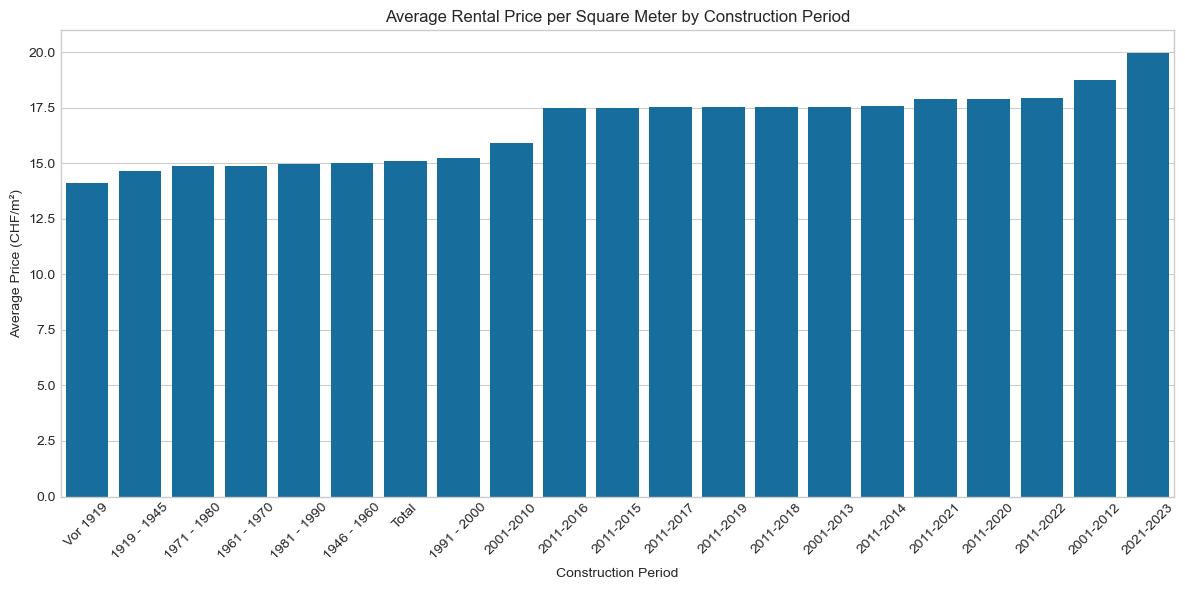

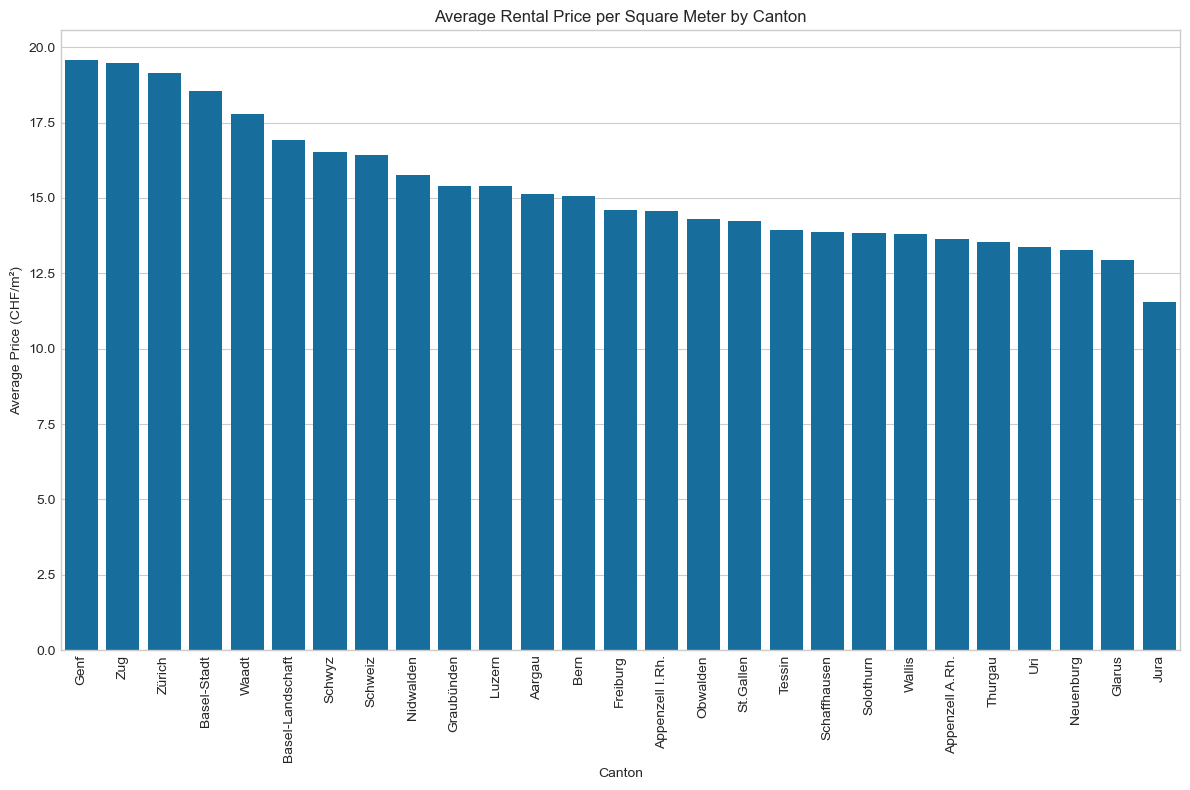

In [37]:
# If you want to examine the data and create visualizations
if data_dict:
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    
    # Create a visualization of prices by construction period
    plt.figure(figsize=(12, 6))
    period_avg = combined_df.groupby('construction_period')['avg_price_per_sqm'].mean().sort_values()
    sns.barplot(x=period_avg.index, y=period_avg.values)
    plt.title('Average Rental Price per Square Meter by Construction Period')
    plt.xlabel('Construction Period')
    plt.ylabel('Average Price (CHF/m²)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create a visualization of prices by canton
    plt.figure(figsize=(12, 8))
    canton_avg = combined_df.groupby('canton')['avg_price_per_sqm'].mean().sort_values(ascending=False)
    sns.barplot(x=canton_avg.index, y=canton_avg.values)
    plt.title('Average Rental Price per Square Meter by Canton')
    plt.xlabel('Canton')
    plt.ylabel('Average Price (CHF/m²)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [24]:
def process_multiple_files(file_paths, output_dir="extracted_data", output_format="json"):  # Changed default to json
    """
    Process multiple Excel files with Swiss rental price data.
    
    Args:
        file_paths (list): List of paths to Excel files
        output_dir (str): Directory to save extracted data
        output_format (str): Format to save extracted data ('csv', 'json', or 'excel')
        
    Returns:
        dict: Dictionary with file names as keys and data dictionaries as values
    """
    extractor = SwissRentalDataExtractor(output_format=output_format)
    all_files_data = {}
    
    for file_path in file_paths:
        if os.path.isfile(file_path) and file_path.endswith(('.xlsx', '.xls')):
            file_data = extractor.extract_data(file_path, output_dir)
            all_files_data[os.path.basename(file_path)] = file_data
        else:
            print(f"Skipping invalid file: {file_path}")
            
    return all_files_data

# Example usage:
# file_paths = ["file1.xlsx", "file2.xlsx", "file3.xlsx"]
# all_files_data = process_multiple_files(file_paths)